In [1]:
import os
import random
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# 0 = Tidak Segar
# 1 = Segar
LABEL_MAP = {
    "Fresh": 1,
    "Highly Fresh": 1,
    "Not Fresh": 0
}


In [3]:
class FishFreshnessFlatDataset(Dataset):
    def __init__(self, root_dir, transform=None, split="train"):
        self.transform = transform
        self.samples = []

        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            if not os.path.isdir(folder_path):
                continue

            if " - " not in folder:
                continue

            fish, condition = folder.split(" - ", 1)
            condition = condition.strip()

            if condition not in LABEL_MAP:
                continue

            label = LABEL_MAP[condition]

            for img in os.listdir(folder_path):
                if img.lower().endswith((".jpg", ".jpeg", ".png")):
                    self.samples.append(
                        (os.path.join(folder_path, img), label, fish)
                    )

        random.shuffle(self.samples)

        n = len(self.samples)
        train_end = int(0.7 * n)
        val_end   = int(0.85 * n)

        if split == "train":
            self.samples = self.samples[:train_end]
        elif split == "val":
            self.samples = self.samples[train_end:val_end]
        else:
            self.samples = self.samples[val_end:]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label, fish = self.samples[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label, fish


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [5]:
DATASET_DIR = "dataset_asli"  # ganti sesuai path kamu

train_ds = FishFreshnessFlatDataset(DATASET_DIR, transform, split="train")
val_ds   = FishFreshnessFlatDataset(DATASET_DIR, transform, split="val")
test_ds  = FishFreshnessFlatDataset(DATASET_DIR, transform, split="test")

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False)

print("Train:", len(train_ds))
print("Val  :", len(val_ds))
print("Test :", len(test_ds))


Train: 3073
Val  : 658
Test : 659


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = efficientnet_v2_s(
    weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1
)

# Freeze seluruh backbone
for p in model.features.parameters():
    p.requires_grad = False

# 🔥 UNFREEZE 2 BLOCK TERAKHIR
for p in model.features[-2:].parameters():
    p.requires_grad = True

# Binary classifier
model.classifier[1] = nn.Linear(
    model.classifier[1].in_features, 2
)

model = model.to(device)


In [7]:
# Bobot manual (lebih stabil dari balanced)
class_weights = torch.tensor([1.4, 0.9]).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)


In [8]:
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-5
)

EPOCHS = 35

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0

    for imgs, labels, _ in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {running_loss:.4f}")


Epoch 1/35 | Loss: 131.3730
Epoch 2/35 | Loss: 123.3497
Epoch 3/35 | Loss: 115.4057
Epoch 4/35 | Loss: 105.9291
Epoch 5/35 | Loss: 97.5864
Epoch 6/35 | Loss: 90.2240
Epoch 7/35 | Loss: 82.3982
Epoch 8/35 | Loss: 76.4272
Epoch 9/35 | Loss: 71.7778
Epoch 10/35 | Loss: 67.4486
Epoch 11/35 | Loss: 60.6466
Epoch 12/35 | Loss: 57.6519
Epoch 13/35 | Loss: 51.3592
Epoch 14/35 | Loss: 48.3985
Epoch 15/35 | Loss: 45.2543
Epoch 16/35 | Loss: 43.0141
Epoch 17/35 | Loss: 36.6831
Epoch 18/35 | Loss: 34.2268
Epoch 19/35 | Loss: 34.8141
Epoch 20/35 | Loss: 30.8715
Epoch 21/35 | Loss: 28.7642
Epoch 22/35 | Loss: 28.3756
Epoch 23/35 | Loss: 26.3920
Epoch 24/35 | Loss: 25.1789
Epoch 25/35 | Loss: 22.3909
Epoch 26/35 | Loss: 20.7058
Epoch 27/35 | Loss: 21.2312
Epoch 28/35 | Loss: 18.9100
Epoch 29/35 | Loss: 19.3164
Epoch 30/35 | Loss: 19.7651
Epoch 31/35 | Loss: 17.6369
Epoch 32/35 | Loss: 17.3416
Epoch 33/35 | Loss: 14.6767
Epoch 34/35 | Loss: 15.7828
Epoch 35/35 | Loss: 14.7031


In [9]:
torch.save(model.state_dict(), "efficientnetv2_final_model_v2.pth")


In [10]:
y_true, y_pred, fish_names = [], [], []

model.eval()
with torch.no_grad():
    for imgs, labels, fish in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().item()

        y_true.append(labels.item())
        y_pred.append(preds)
        fish_names.append(fish[0])


In [11]:
print("Accuracy :", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall   :", recall_score(y_true, y_pred))
print("F1-score :", f1_score(y_true, y_pred))

print("\nClassification Report:\n")
print(classification_report(
    y_true, y_pred,
    target_names=["Tidak Segar", "Segar"]
))


Accuracy : 0.9408194233687405
Precision: 0.9582417582417583
Recall   : 0.956140350877193
F1-score : 0.9571899012074643

Classification Report:

              precision    recall  f1-score   support

 Tidak Segar       0.90      0.91      0.90       203
       Segar       0.96      0.96      0.96       456

    accuracy                           0.94       659
   macro avg       0.93      0.93      0.93       659
weighted avg       0.94      0.94      0.94       659



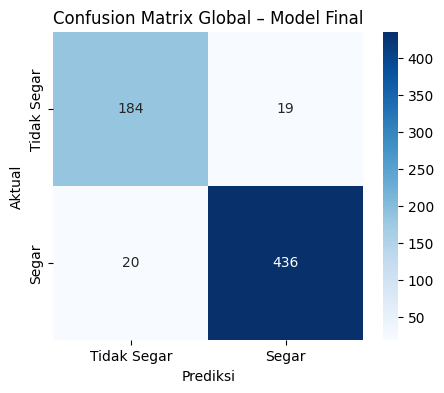

In [12]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=["Tidak Segar", "Segar"],
    yticklabels=["Tidak Segar", "Segar"],
    cmap="Blues"
)
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix Global – Model Final")
plt.show()
    

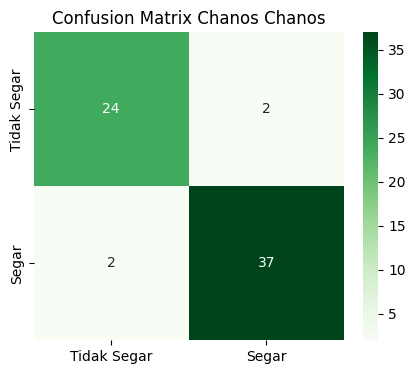

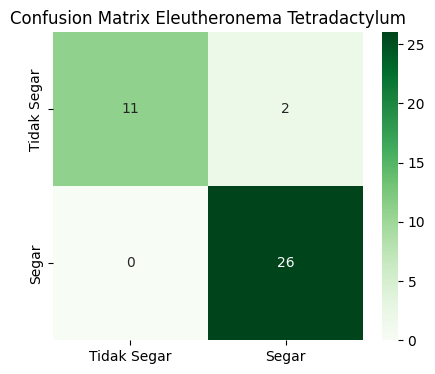

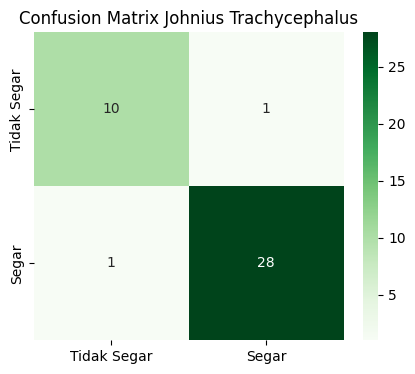

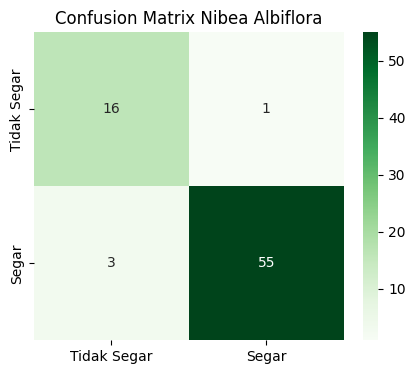

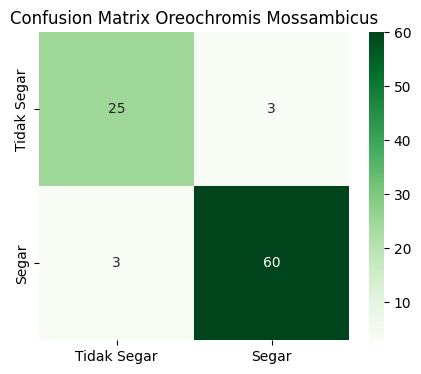

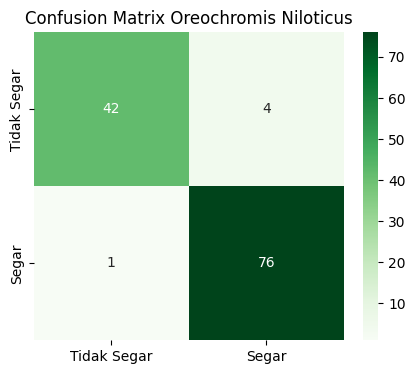

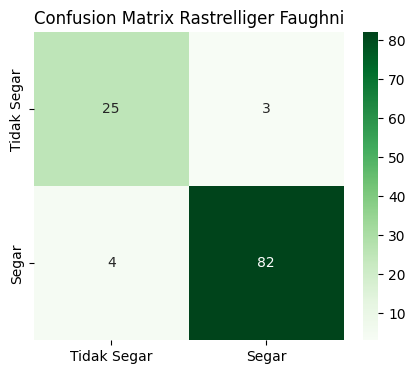

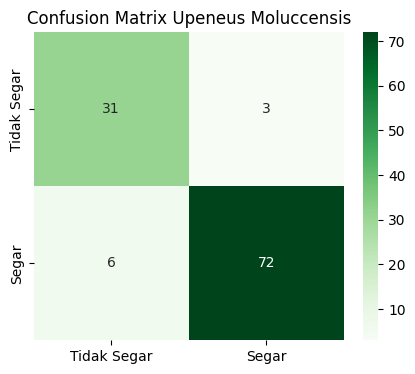

In [13]:
for fish in sorted(set(fish_names)):
    idx = [i for i, f in enumerate(fish_names) if f == fish]

    cm_fish = confusion_matrix(
        [y_true[i] for i in idx],
        [y_pred[i] for i in idx],
        labels=[0, 1]
    )

    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm_fish, annot=True, fmt="d",
        xticklabels=["Tidak Segar", "Segar"],
        yticklabels=["Tidak Segar", "Segar"],
        cmap="Greens"
    )
    plt.title(f"Confusion Matrix {fish}")
    plt.show()


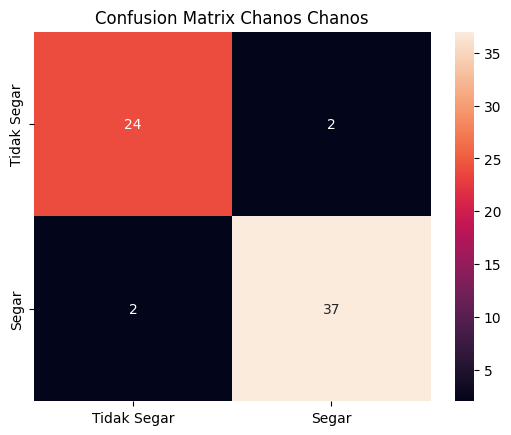

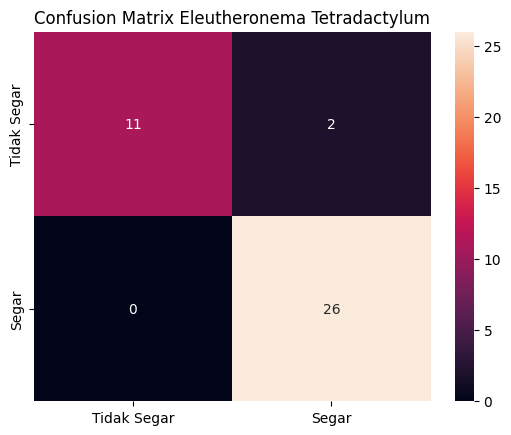

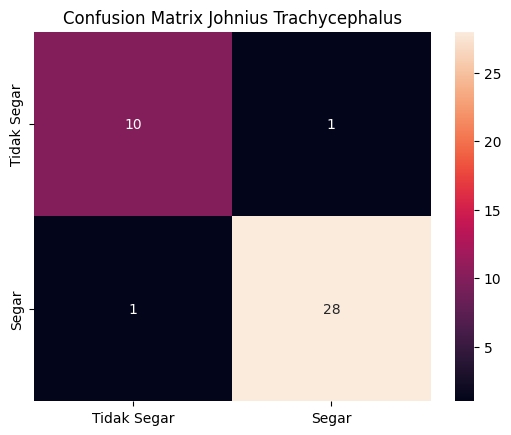

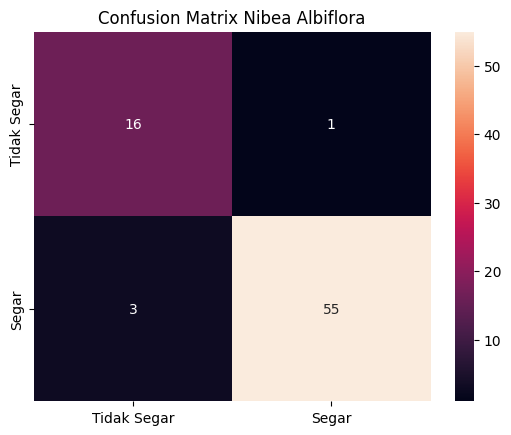

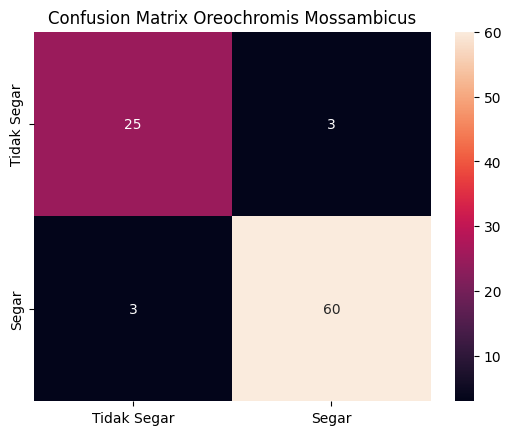

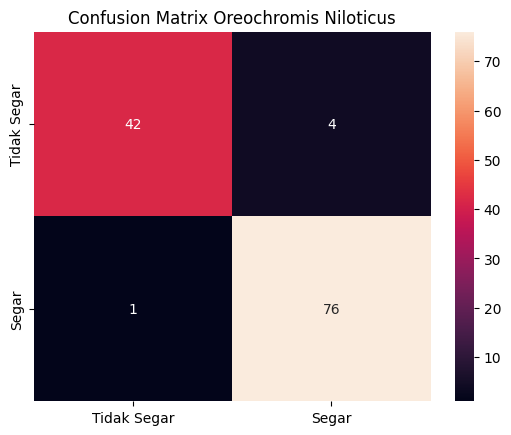

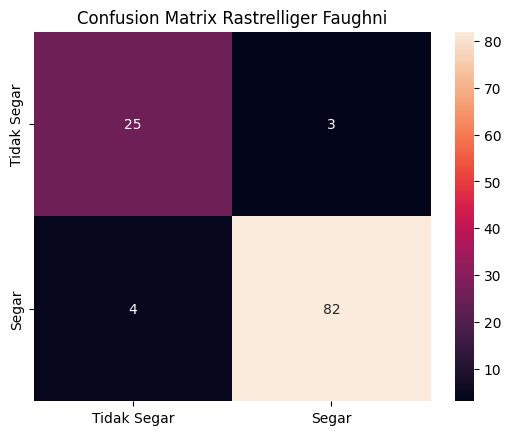

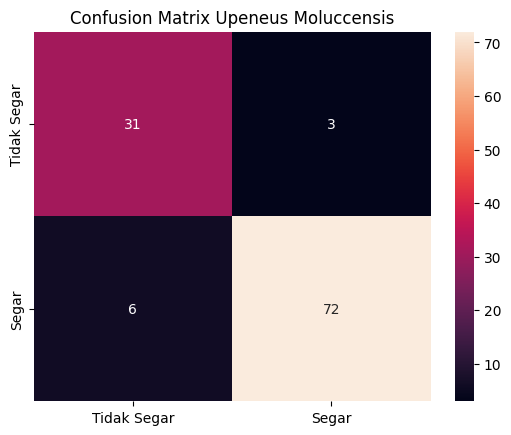

In [14]:
for fish in sorted(set(fish_names)):
    idx = [i for i, f in enumerate(fish_names) if f == fish]

    cm_fish = confusion_matrix(
        [y_true[i] for i in idx],
        [y_pred[i] for i in idx],
        labels=[0, 1]
    )

    sns.heatmap(
        cm_fish, annot=True, fmt="d",
        xticklabels=["Tidak Segar", "Segar"],
        yticklabels=["Tidak Segar", "Segar"]
    )
    plt.title(f"Confusion Matrix {fish}")
    plt.show()
